In [1]:
%load_ext autoreload
%autoreload 2

In [390]:
import slippi
from slippi import Game
import pickle
import pandas as pd
import glob
import numpy as np
from tqdm import tqdm 

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, KFold

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import log_loss,accuracy_score, roc_curve
from sklearn.base import clone
from sklearn.tree import DecisionTreeClassifier

from ipywidgets import interact

pd.set_option('display.max_columns', None)


import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt

from utils.data_utils import construct_df, ohe_chars_stage, characters, stages, stage_dict, construct_df_igs,\
                        process_df_igs, process_df_igs_final, make_rows_igs, get_ports, get_characters, get_winner
from utils.modeling_utils import plot_log_loss, plot_multiple_log_loss, CV_model, plot_feature_importances,\
                            plot_win_probs, get_log_losses, validate_model

import plotly.graph_objects as go


In [3]:
gs_5s_igs = pd.read_pickle('saved_data/gs_5s_igs.pkl')
fp9_5s_igs=pd.read_pickle('saved_data/fp9_5s_igs.pkl')
p2019_5s_igs = pd.read_pickle('saved_data/p2019_5s_igs.pkl')
nma2_5s_igs = pd.read_pickle('saved_data/nma2_5s_igs.pkl')
fb5_5s_igs=pd.read_pickle('saved_data/fb5_5s_igs.pkl')

In [391]:
df,features = process_df_igs_final(pd.concat([gs_5s_igs, fp9_5s_igs,p2019_5s_igs,nma2_5s_igs,fb5_5s_igs]).reset_index(drop=True))


In [5]:
drop_games = ['Game_20190309T155715', 'Game_20190309T160751']
df = df[~df['id'].isin(drop_games)]

In [6]:
df

,id,p1_char,p2_char,stage,frames_elapsed,p1_stocks,p2_stocks,p1_damage,p2_damage,winner,p1_total_hits,p1_ground_hits,p1_smash_hits,p1_aerial_hits,p1_grabs,p1_shield_frames,p1_rolls,p1_early_stocks_lost,p1_frames_since_lost,p2_total_hits,p2_ground_hits,p2_smash_hits,p2_aerial_hits,p2_grabs,p2_shield_frames,p2_rolls,p2_early_stocks_lost,p2_frames_since_lost,p1_FOX,p1_FALCO,p1_MARTH,p1_SHEIK,p1_JIGGLYPUFF,p1_PEACH,p1_ICE_CLIMBERS,p1_CAPTAIN_FALCON,p1_PIKACHU,p1_SAMUS,p1_DR_MARIO,p1_YOSHI,p1_LUIGI,p1_GANONDORF,p1_MARIO,p1_YOUNG_LINK,p1_DONKEY_KONG,p1_LINK,p1_GAME_AND_WATCH,p1_ROY,p1_MEWTWO,p1_ZELDA,p1_NESS,p1_PICHU,p1_BOWSER,p1_KIRBY,p2_FOX,p2_FALCO,p2_MARTH,p2_SHEIK,p2_JIGGLYPUFF,p2_PEACH,p2_ICE_CLIMBERS,p2_CAPTAIN_FALCON,p2_PIKACHU,p2_SAMUS,p2_DR_MARIO,p2_YOSHI,p2_LUIGI,p2_GANONDORF,p2_MARIO,p2_YOUNG_LINK,p2_DONKEY_KONG,p2_LINK,p2_GAME_AND_WATCH,p2_ROY,p2_MEWTWO,p2_ZELDA,p2_NESS,p2_PICHU,p2_BOWSER,p2_KIRBY,stage_BATTLEFIELD,stage_FINAL_DESTINATION,stage_DREAM_LAND_N64,stage_YOSHIS_STORY,stage_FOUNTAIN_OF_DREAMS,stage_POKEMON_STADIUM,hit_diff,shield_diff,early_stock_diff,grab_diff,stock_diff_sc
0,Game_20190309T134133,FOX,MARTH,BATTLEFIELD,0,4.0,4.0,0.000000,0.000000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Game_20190309T134133,FOX,MARTH,BATTLEFIELD,300,4.0,4.0,0.000000,0.000000,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,300.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,300.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,Game_20190309T134133,FOX,MARTH,BATTLEFIELD,600,4.0,4.0,27.440001,0.000000,0,0.0,0.0,0.0,0.0,0.0,8.0,1.0,0.0,600.0,5.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,600.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-5.0,8.0,0.0,-2.0,0.0
3,Game_20190309T134133,FOX,MARTH,BATTLEFIELD,900,4.0,4.0,52.270004,0.000000,0,0.0,0.0,0.0,0.0,0.0,8.0,1.0,0.0,900.0,7.0,0.0,1.0,2.0,2.0,16.0,0.0,0.0,900.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-7.0,-8.0,0.0,-2.0,0.0
4,Game_20190309T134133,FOX,MARTH,BATTLEFIELD,1200,4.0,4.0,95.940002,0.000000,0,0.0,0.0,0.0,0.0,0.0,8.0,1.0,0.0,1200.0,11.0,1.0,1.0,5.0,2.0,55.0,0.0,0.0,1200.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-11.0,-47.0,0.0,-2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
615714,Game_20190324T140926,SHEIK,FOX,FINAL_DESTINATION,9900,1.0,3.0,25.629999,71.438156,0,36.0,7.0,2.0,11.0,6.0,282.0,6.0,0.0,1496.0,80.0,6.0,1.0,34.0,10.0,363.0,0.0,0.0,2616.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-44.0,-81.0,0.0,-4.0,-80.0
615715,Game_20190324T140926,SHEIK,FOX,FINAL_DEST

In [187]:
df.to_pickle('saved_data/final_processed_data.pkl')

In [7]:
df_train, df_test = train_test_split(df, test_size=0.2)


In [8]:
X_train = df_train[features]
y_train = df_train['winner']

X_test = df_test[features]
y_test = df_test['winner']

In [9]:
model = ExtraTreesClassifier(n_jobs=6, n_estimators=100, ccp_alpha=.000001,max_features=5, min_samples_split=4)

In [10]:
model.fit(X_train,y_train)

ExtraTreesClassifier(ccp_alpha=1e-06, max_features=5, min_samples_split=4,
                     n_jobs=6)

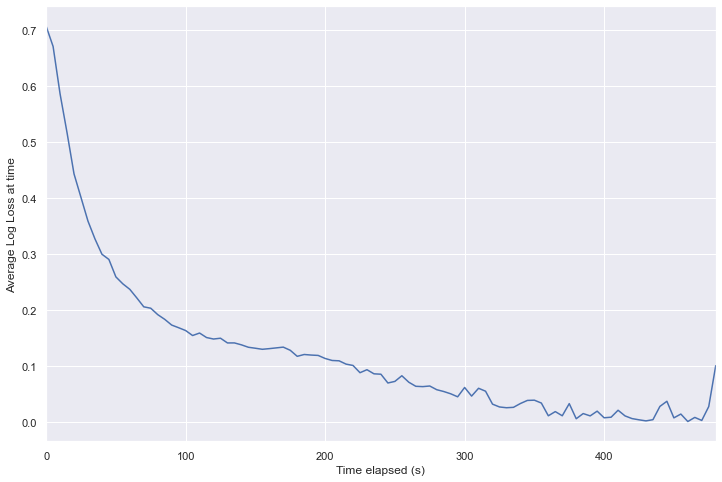

In [11]:
plot_log_loss(X_test,y_test,model)

In [12]:
log_loss(y_test, model.predict_proba(X_test))

0.25412495619519526

In [13]:
accuracy_score(y_test, model.predict(X_test))

0.9258546175342822

In [156]:
X_test

,frames_elapsed,p1_stocks,p2_stocks,p1_damage,p2_damage,p1_total_hits,p1_ground_hits,p1_smash_hits,p1_aerial_hits,p1_grabs,p1_shield_frames,p1_rolls,p1_early_stocks_lost,p1_frames_since_lost,p2_total_hits,p2_ground_hits,p2_smash_hits,p2_aerial_hits,p2_grabs,p2_shield_frames,p2_rolls,p2_early_stocks_lost,p2_frames_since_lost,p1_FOX,p1_FALCO,p1_MARTH,p1_SHEIK,p1_JIGGLYPUFF,p1_PEACH,p1_ICE_CLIMBERS,p1_CAPTAIN_FALCON,p1_PIKACHU,p1_SAMUS,p1_DR_MARIO,p1_YOSHI,p1_LUIGI,p1_GANONDORF,p1_MARIO,p1_YOUNG_LINK,p1_DONKEY_KONG,p1_LINK,p1_GAME_AND_WATCH,p1_ROY,p1_MEWTWO,p1_ZELDA,p1_NESS,p1_PICHU,p1_BOWSER,p1_KIRBY,p2_FOX,p2_FALCO,p2_MARTH,p2_SHEIK,p2_JIGGLYPUFF,p2_PEACH,p2_ICE_CLIMBERS,p2_CAPTAIN_FALCON,p2_PIKACHU,p2_SAMUS,p2_DR_MARIO,p2_YOSHI,p2_LUIGI,p2_GANONDORF,p2_MARIO,p2_YOUNG_LINK,p2_DONKEY_KONG,p2_LINK,p2_GAME_AND_WATCH,p2_ROY,p2_MEWTWO,p2_ZELDA,p2_NESS,p2_PICHU,p2_BOWSER,p2_KIRBY,stage_BATTLEFIELD,stage_FINAL_DESTINATION,stage_DREAM_LAND_N64,stage_YOSHIS_STORY,stage_FOUNTAIN_OF_DREAMS,stage_POKEMON_STADIUM,hit_diff,shield_diff,early_stock_diff,grab_diff,stock_diff_sc
333687,8100,1.0,2.0,0.000000,8.700000,49.0,4.0,3.0,14.0,3.0,102.0,0.0,0.0,120.0,64.0,8.0,3.0,24.0,5.0,328.0,3.0,0.0,1733.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-15.0,-226.0,0.0,-2.0,-15.0
313760,3600,3.0,4.0,103.190002,51.000000,5.0,1.0,0.0,3.0,0.0,167.0,3.0,0.0,1912.0,30.0,9.0,1.0,4.0,11.0,106.0,2.0,0.0,3600.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-25.0,61.0,0.0,-11.0,-175.0
266754,6600,3.0,2.0,44.750000,100.349998,47.0,2.0,2.0,16.0,6.0,257.0,2.0,0.0,1212.0,28.0,1.0,0.0,9.0,1.0,188.0,1.0,1.0,1857.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,19.0,69.0,-1.0,5.0,65.0
519234,4800,2.0,4.0,88.250000,94.219994,7.0,0.0,5.0,1.0,0.0,181.0,3.0,0.0,1112.0,37.0,4.0,0.0,18.0,1.0,152.0,1.0,0.0,4800.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-30.0,29.0,0.0,-1.0,-240.0
337112,300,4.0,4.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,300.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,300.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257568,7200,3.0,2.0,56.469997,21.450001,33.0,3.0,4.0,13.0,1.0,207.0,1.0,0.0,2555.0,29.0,3.0,1.0,14.0,1.0,510.0,5.0,0.0,937.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,-303.0,0.0,0.0,65.0
488851,0,4.0,4.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [179]:
win_calibration_df = pd.DataFrame(data = {'winner':y_test, 'predicted_prob':model.predict_proba(X_test)[:,1]})

In [180]:
win_calibration_df['prob_bin']=pd.cut(win_calibration_df['predicted_prob'],np.arange(0,1,.01))

In [181]:
categories = win_calibration_df['prob_bin'].cat.categories

In [192]:
win_pct = win_calibration_df.groupby(['prob_bin'])['winner'].mean()

In [193]:
win_pct

prob_bin
(0.0, 0.01]     0.000000
(0.01, 0.02]    0.000000
(0.02, 0.03]    0.000390
(0.03, 0.04]    0.000740
(0.04, 0.05]    0.000386
                  ...   
(0.94, 0.95]    1.000000
(0.95, 0.96]    0.999183
(0.96, 0.97]    0.999600
(0.97, 0.98]    0.999573
(0.98, 0.99]    0.999496
Name: winner, Length: 99, dtype: float64

In [184]:
cal_df_mean = pd.DataFrame.from_records(list(zip(categories.right, win_pct)),columns=['tick','pct'])


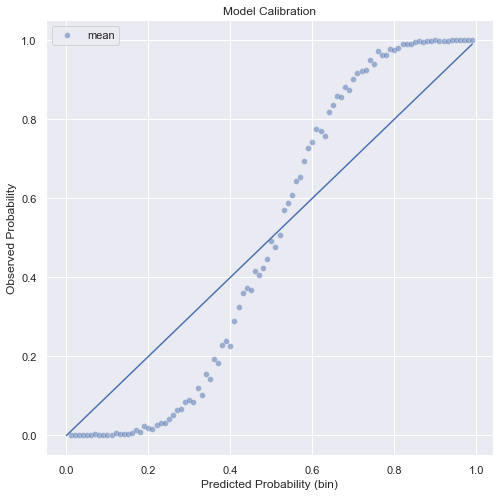

In [188]:
plt.figure(figsize=(8,8))
sns.scatterplot(data=cal_df_mean,x='tick',y='pct',label='mean',alpha=0.5)
plt.plot(np.arange(0,1,0.01),np.arange(0,1,0.01))
plt.title('Model Calibration')
plt.xlabel('Predicted Probability (bin)')
plt.ylabel('Observed Probability')
plt.show()

This is pretty intersting - at first glance it might seem like the model isn't well calibrated, and I suppose maybe it isn't. This is telling us that if the model predicts that the odds p1 wins are 80%, really there's a >95% chance they win in practice. This means the model gives too much of a chance to people that are winning and to little of a chance to people who are winning. Obviously this isn't the best but given the fact that I want to show win probability graphs maybe its not too much of a bad thing. When I'm showing win probabilities the actual numbers down to the percent aren't as important as the overall trends in the game. 

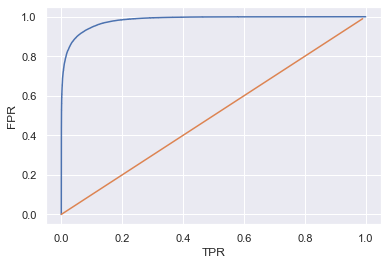

In [361]:
fpr, tpr, thresholds =roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr)
plt.plot(np.arange(0,1,0.01),np.arange(0,1,0.01))
plt.xlabel('TPR')
plt.ylabel('FPR')
plt.show()

In [14]:
with open('saved_data/final_model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [277]:
test_game = Game('replays/mangozain.slp')
test_game2 = Game('replays/mangoaxe.slp')
test_game3 = Game('replays/test.slp')
test_game4 = Game('replays/4stockp1.slp')

In [384]:
class GameStats():
    def __init__(self, game, model,features):
        self.game = game
        self.model = model
        self.features = features
        self.port1, self.port2 = get_ports(self.game)
        self.char1, self.char2 = get_characters(self.game, self.port1, self.port2)
        self.char1, self.char2 = self.char1.title(), self.char2.title()
        self.stage = stage_dict[self.game.start.stage.name]
        self.winner = get_winner(self.game, self.port1, self.port2)
        
        self.game_df,f = self.make_game_df()
        self.p1_odds = self.get_p1_odds()
        self.p2_odds = 1-self.p1_odds
    
    def make_game_df(self):
        df_list = []
        rows = make_rows_igs(self.game, 1, '')
        df_list.append(rows)
        return process_df_igs_final(pd.concat(df_list).reset_index(drop=True))
       
    def get_p1_odds(self):
        """Return odds over time of p1 winning"""
        return  model.predict_proba(self.game_df[features])[:,1]
    
    def get_final_stat(self,feature):
        try:
            return self.game_df.iloc[-1][feature]
        except:
            print('Feature not in feature list')
            return None
    
    def lead_changes(self):
        leads = np.rint(self.p1_odds)
        changes = 0
        for i in range(10,len(leads)):
            if leads[i] != leads[i-1]:
                changes +=1
        return changes
    
    def closeness_factor(self):
        """
        Percent of seconds spent betwen 35 and 65 percent odds
        """
        num_seconds_close = len(self.p1_odds[(self.p1_odds >=.35)&(self.p1_odds <=.65)])
        return round(num_seconds_close/len(self.p1_odds)*100)
    
    
    def comeback_factor(self):
        lowest_odds = 0
        if self.winner == 1:
            lowest_odds = np.min(self.p1_odds[10:])
        if self.winner == 0:
            lowest_odds = np.min(self.p2_odds[10:])
        return max(100 - 2*round(lowest_odds *100),0)
        
        
    
    def turning_point(self):
        """
        Returns time when winner passed 50% odds and never went below 50%
        If the winner wasn't above 50% will return something else
        """
        if self.winner == 1:
            for i, odds in enumerate(self.p1_odds[::-1]):
                if odds <.5:
                    return len(self.p1_odds)-i
        if self.winner == 0 :
            for i, odds in enumerate(self.p2_odds[::-1]):
                if odds <.5:
                    return len(self.p2_odds)-i
        return 0
    
    def clutch(self,window=20):
        """
        Returns True if the average win probability of the winner of the game was less than .5 in the last window
        seconds of the game
        """
        if self.winner == 1:
            return np.mean(self.p1_odds[-window:])<.5
        else:
            return np.mean(self.p2_odds[-window:])<.5
     
    def get_stock_loss_times(self):
        p1_losses = []
        p2_losses = []
        p1_stocks = 4
        p2_stocks = 4
        for i,frame in enumerate(self.game.frames):
            if frame.ports[self.port1].leader.post.stocks < p1_stocks:
                p1_losses.append(i/60)
                p1_stocks -=1
            if frame.ports[self.port2].leader.post.stocks < p2_stocks:
                p2_losses.append(i/60)
                p2_stocks -=1
        return p1_losses, p2_losses
    
    def plot_odds(self,show_stocks=True):
        time = self.game_df['frames_elapsed']/60
        fig = go.Figure()

        fig.add_trace(
            go.Scatter(x=time, y=self.p1_odds,name = f'P1 ({self.char1})'))
        
        fig.add_trace(
            go.Scatter(x=time, y=self.p2_odds,name = f'P2 ({self.char2})'))
        
        # Set title
        fig.update_layout(
            title_text=f'{self.char1} vs {self.char2} on {self.stage}', title_x = 0.45
        )
        fig.update_layout(xaxis = dict(title='Time (s)'))
        fig.update_layout(yaxis = dict(title='Win Probability'))

        fig.update_traces(hovertemplate='%{y:.2f}')
        fig.update_layout(hovermode="x unified")
        p1_losses, p2_losses = self.get_stock_loss_times()
        if show_stocks:
            for loss in p1_losses:
                fig.add_vline(x=loss, line_dash = 'dash', line_color='blue')
            for loss in p2_losses:
                fig.add_vline(x=loss, line_dash = 'dash', line_color='red')
        fig.add_hline(y=.5, line_width=.75, line_dash = 'dash', line_color= 'black')
        fig.show()

In [385]:
TestGS = GameStats(test_game4,model,features)
TestGS.plot_odds(show_stocks=True)

In [364]:
print(TestGS.lead_changes())
print(TestGS.closeness_factor())
print(TestGS.comeback_factor())
print(TestGS.turning_point())
print(TestGS.clutch())

0
8
0
3
False


In [387]:
TestGS.get_final_stat('p1_aerial_hit')

Feature not in feature list


In [380]:
TestGS.game_df.columns

Index(['id', 'p1_char', 'p2_char', 'stage', 'frames_elapsed', 'p1_stocks',
       'p2_stocks', 'p1_damage', 'p2_damage', 'winner', 'p1_total_hits',
       'p1_ground_hits', 'p1_smash_hits', 'p1_aerial_hits', 'p1_grabs',
       'p1_shield_frames', 'p1_rolls', 'p1_early_stocks_lost',
       'p1_frames_since_lost', 'p2_total_hits', 'p2_ground_hits',
       'p2_smash_hits', 'p2_aerial_hits', 'p2_grabs', 'p2_shield_frames',
       'p2_rolls', 'p2_early_stocks_lost', 'p2_frames_since_lost', 'p1_FOX',
       'p1_FALCO', 'p1_MARTH', 'p1_SHEIK', 'p1_JIGGLYPUFF', 'p1_PEACH',
       'p1_ICE_CLIMBERS', 'p1_CAPTAIN_FALCON', 'p1_PIKACHU', 'p1_SAMUS',
       'p1_DR_MARIO', 'p1_YOSHI', 'p1_LUIGI', 'p1_GANONDORF', 'p1_MARIO',
       'p1_YOUNG_LINK', 'p1_DONKEY_KONG', 'p1_LINK', 'p1_GAME_AND_WATCH',
       'p1_ROY', 'p1_MEWTWO', 'p1_ZELDA', 'p1_NESS', 'p1_PICHU', 'p1_BOWSER',
       'p1_KIRBY', 'p2_FOX', 'p2_FALCO', 'p2_MARTH', 'p2_SHEIK',
       'p2_JIGGLYPUFF', 'p2_PEACH', 'p2_ICE_CLIMBERS', 'p2_CAPTA

In [200]:
prob_check = construct_df_igs(['replays/mangozain.slp'],1)
prob_check,all_diff_feats = process_df_igs_final(prob_check)
prob_check2 = construct_df_igs(['replays/4stockp1.slp'],1)
prob_check2,all_diff_feats = process_df_igs_final(prob_check2)
prob_check3 = construct_df_igs(['replays/test.slp'],1)
prob_check3,all_diff_feats = process_df_igs_final(prob_check3)
prob_check4 = construct_df_igs(['replays/test2.slp'],1)
prob_check4,all_diff_feats = process_df_igs_final(prob_check4)

Games parsed: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


In [203]:
prob_check.to_pickle('saved_data/prob_check1.pkl')